# Satellite Image Land Cover Classification

Dataset used - EuroSat Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3, MobileNetV2
import os
import PIL

In [2]:
from google.colab import files

# Upload the Kaggle API key JSON file that you obtained from your Kaggle account
uploaded = files.upload()

# Move the uploaded file to the appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!pip install kaggle

In [3]:
# Downloading the dataset using the Kaggle API
!kaggle datasets download -d nilesh789/eurosat-rgb

 79% 71.0M/89.6M [00:00<00:00, 114MB/s]
100% 89.6M/89.6M [00:00<00:00, 133MB/s]


In [ ]:
# Unzip the downloaded dataset
!unzip eurosat-rgb.zip

## Data Preprocessing 

In [5]:
dataset = "/content/2750"

In [6]:
labels = os.listdir(dataset)

num_labels = len(labels)
print(f"Total number of labels: {num_labels}")

# List of labels
print("List of all the labels:")
for label in labels:
    print(label, end=", ")

Total number of labels: 10
List of all the labels:
Forest, PermanentCrop, AnnualCrop, River, Pasture, Highway, SeaLake, Residential, Industrial, HerbaceousVegetation, 

In [7]:
counts = {}

for l in labels:
    counts[l] = len(os.listdir(os.path.join(dataset, l)))

In [8]:
# Display basic dataset statistics
print(f"Total number of images: {sum(counts.values())}")
print(f"Minimum number of images in a class: {min(counts.values())}")
print(f"Maximum number of images in a class: {max(counts.values())}")
print(f"Average number of images per class: {np.mean(list(counts.values())):.2f}")

# Display image dimensions (assuming all images have the same dimensions)
sample_image_path = os.path.join(dataset, labels[0], os.listdir(os.path.join(dataset, labels[0]))[0])
sample_image = PIL.Image.open(sample_image_path)
image_width, image_height = sample_image.size
print(f"Image dimensions: {image_width} x {image_height}")


Total number of images: 27000
Minimum number of images in a class: 2000
Maximum number of images in a class: 3000
Average number of images per class: 2700.00
Image dimensions: 64 x 64


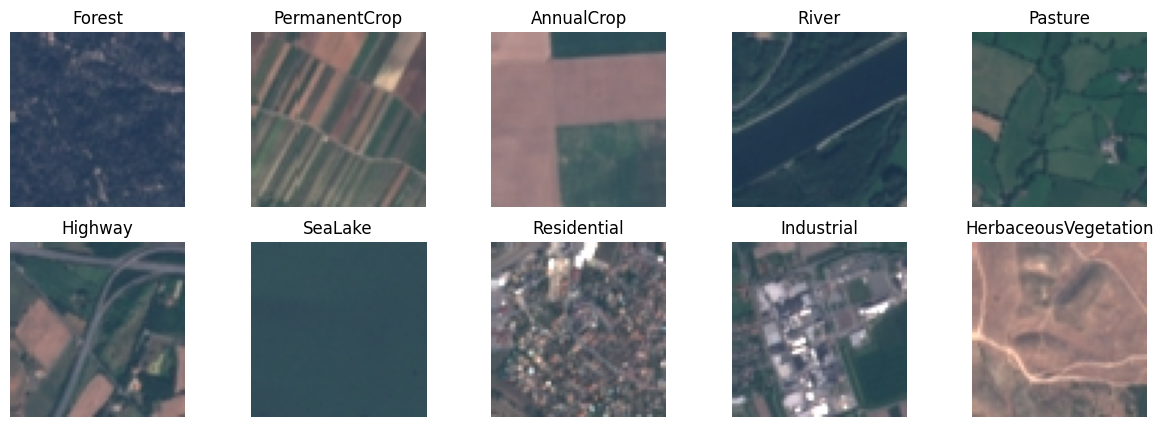

In [ ]:
# Display sample images from each class
plt.figure(figsize=(15, 5))
for i, label in enumerate(labels):
    sample_image_path = os.path.join(dataset, label, os.listdir(os.path.join(dataset, label))[0])
    sample_image = PIL.Image.open(sample_image_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_image)
    plt.title(label)
    plt.axis('off')
plt.show()

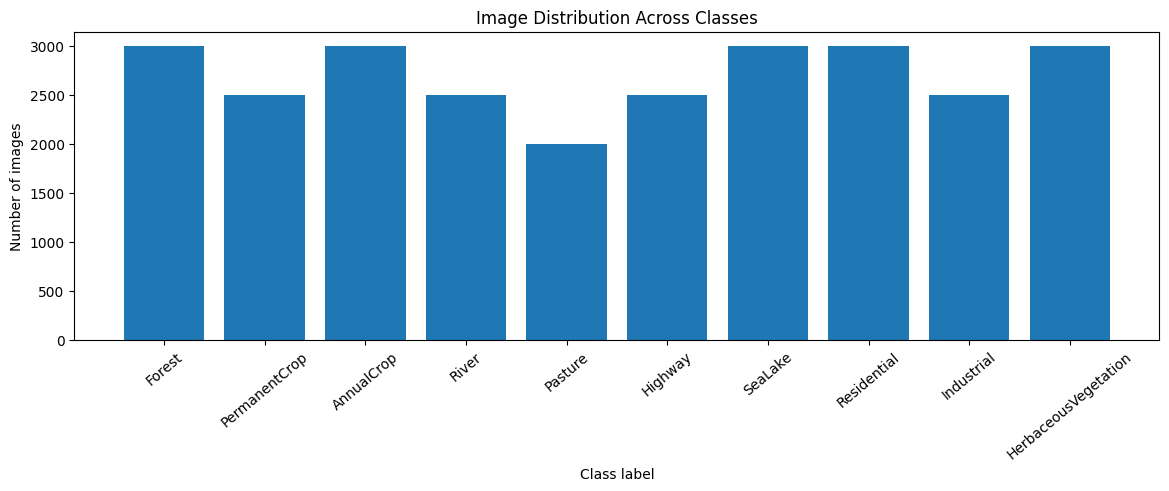

In [ ]:
# Display image distribution across classes
plt.figure(figsize=(14, 4))
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), rotation=40)
plt.xlabel('Class label')
plt.ylabel('Number of images')
plt.title('Image Distribution Across Classes')
plt.show()

In [9]:
from tqdm import tqdm
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator
import shutil

In [10]:
TRAIN_DIR = '/content/train'
TEST_DIR = '/content/test'
BATCH_SIZE = 64
NUM_CLASSES=len(labels)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in labels:

    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [11]:
# map each image path to their class label in 'data'
data = {}

for l in labels:
    for img in os.listdir(dataset+'/'+l):
        data.update({os.path.join(dataset, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):

    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub(dataset, '/content/train', i) for i in train_paths]
    new_test_paths = [re.sub(dataset, '/content/test', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))

    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('train', 'test', i[1])):
                shutil.copy(i[0], i[1])

    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('train', 'test', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


100%|██████████| 21600/21600 [00:04<00:00, 4954.78it/s]


moving testing files..


100%|██████████| 5400/5400 [00:01<00:00, 4130.59it/s]


In [12]:
# ImageDataGenerator Instance for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=True,
    seed=69
)

# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [13]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [14]:
np.save('class_indices', train_generator.class_indices)

### Random Forest Classifier (ML Classifier)

In [15]:
# Using image data generator api in keras for making image dataset
rf_gen = ImageDataGenerator(rescale=1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=21600,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

rf_test_generator = rf_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=5400,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [16]:
train = rf_train_generator.next()
X_train = train[0].reshape(21600, 12288)
y_train = train[1]

test = rf_test_generator.next()
X_test = test[0].reshape(5400, 12288)
y_test = test[1]

In [17]:
# Creating mini batches of training data
ids_1 = np.random.choice(len(X_train), size=21600, replace=False)
X_train_mini_1 = X_train[ids_1]
y_train_mini_1 = rf_train_generator.classes[ids_1]

In [32]:
# random forest classifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score


rf_clf = ensemble.RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=7)
rf_clf.fit(X_train_mini_1, y_train_mini_1)
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_pred, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(acc))

Accuracy Score: 0.6193



Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.68      0.61       600
           1       0.82      0.92      0.87       600
           2       0.51      0.50      0.51       600
           3       0.40      0.30      0.34       500
           4       0.71      0.79      0.75       500
           5       0.66      0.71      0.68       400
           6       0.39      0.27      0.32       500
           7       0.50      0.52      0.51       600
           8       0.59      0.55      0.57       500
           9       0.92      0.88      0.90       600

    accuracy                           0.62      5400
   macro avg       0.60      0.61      0.61      5400
weighted avg       0.61      0.62      0.61      5400



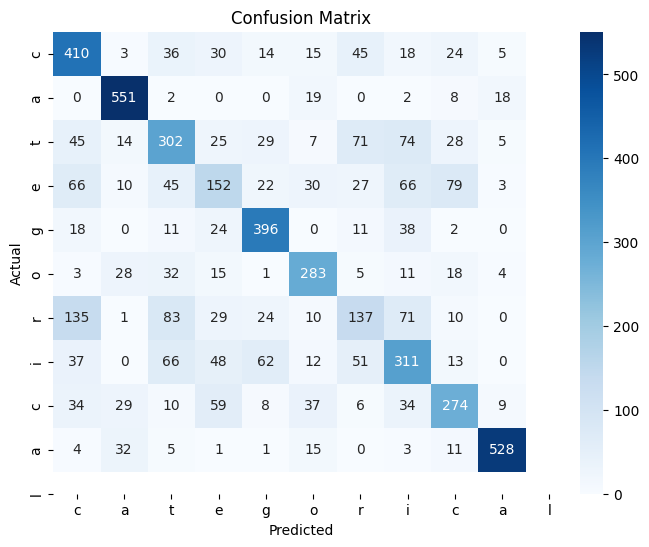

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Display the classification report
print("\nClassification Report:\n", classification_report(rf_test_generator.classes, y_pred))

# Display the confusion matrix
cm = confusion_matrix(rf_test_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_MODE, yticklabels=CLASS_MODE)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Custom CNN Model (Deep Learning Model)

In [24]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [36]:
# CNN

# Image data generators for training and testing
cnn_gen = ImageDataGenerator(rescale=1./255)

cnn_train_generator = cnn_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' for sparse_categorical_crossentropy
    color_mode='rgb',
    shuffle=True,
    seed=7
)

cnn_test_generator = cnn_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' for sparse_categorical_crossentropy
    color_mode='rgb',
    shuffle=False,
    seed=7
)

# Define CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_labels, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit_generator(
    cnn_train_generator,
    steps_per_epoch=len(cnn_train_generator),
    epochs=10,
    validation_data=cnn_test_generator,
    validation_steps=len(cnn_test_generator)
)

# Evaluate the CNN model
cnn_eval = cnn_model.evaluate_generator(cnn_test_generator, steps=len(cnn_test_generator))
print("CNN Model - Test Accuracy: {:.4f}".format(cnn_eval[1]))


Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


<ipython-input-36-6e9a7d0e1fa2>:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model.fit_generator(


Epoch 1/10
675/675 [==============================] - 108s 156ms/step - loss: 1.2612 - accuracy: 0.5250 - val_loss: 1.0517 - val_accuracy: 0.6046
Epoch 2/10
675/675 [==============================] - 104s 154ms/step - loss: 0.9012 - accuracy: 0.6729 - val_loss: 0.8129 - val_accuracy: 0.7067
Epoch 3/10
675/675 [==============================] - 101s 150ms/step - loss: 0.7418 - accuracy: 0.7292 - val_loss: 0.7366 - val_accuracy: 0.7394
Epoch 4/10
675/675 [==============================] - 99s 146ms/step - loss: 0.6381 - accuracy: 0.7720 - val_loss: 0.7583 - val_accuracy: 0.7269
Epoch 5/10
675/675 [==============================] - 95s 140ms/step - loss: 0.5530 - accuracy: 0.8025 - val_loss: 0.8693 - val_accuracy: 0.6935
Epoch 6/10
675/675 [==============================] - 95s 140ms/step - loss: 0.4853 - accuracy: 0.8278 - val_loss: 0.6831 - val_accuracy: 0.7585
Epoch 7/10
675/675 [==============================] - 95s 141ms/step - loss: 0.4409 - accuracy: 0.8463 - val_loss: 0.7572 - val

<ipython-input-36-6e9a7d0e1fa2>:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  cnn_eval = cnn_model.evaluate_generator(cnn_test_generator, steps=len(cnn_test_generator))


CNN Model - Test Accuracy: 0.7756


<ipython-input-37-5533a7116db4>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn_model.fit_generator(


Epoch 1/10
675/675 [==============================] - 96s 142ms/step - loss: 0.2738 - accuracy: 0.9077 - val_loss: 0.7702 - val_accuracy: 0.7728
Epoch 2/10
675/675 [==============================] - 96s 142ms/step - loss: 0.2436 - accuracy: 0.9169 - val_loss: 0.7701 - val_accuracy: 0.7722
Epoch 3/10
675/675 [==============================] - 94s 139ms/step - loss: 0.2213 - accuracy: 0.9234 - val_loss: 0.7714 - val_accuracy: 0.7854
Epoch 4/10
675/675 [==============================] - 95s 140ms/step - loss: 0.1968 - accuracy: 0.9355 - val_loss: 0.7989 - val_accuracy: 0.7802
Epoch 5/10
675/675 [==============================] - 93s 138ms/step - loss: 0.1746 - accuracy: 0.9417 - val_loss: 0.8996 - val_accuracy: 0.7541
Epoch 6/10
675/675 [==============================] - 103s 153ms/step - loss: 0.1489 - accuracy: 0.9525 - val_loss: 1.0667 - val_accuracy: 0.7313
Epoch 7/10
675/675 [==============================] - 93s 138ms/step - loss: 0.1505 - accuracy: 0.9504 - val_loss: 1.0833 - val_a

<ipython-input-37-5533a7116db4>:11: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  cnn_eval = cnn_model.evaluate_generator(cnn_test_generator, steps=len(cnn_test_generator))


CNN Model - Test Accuracy: 0.7731


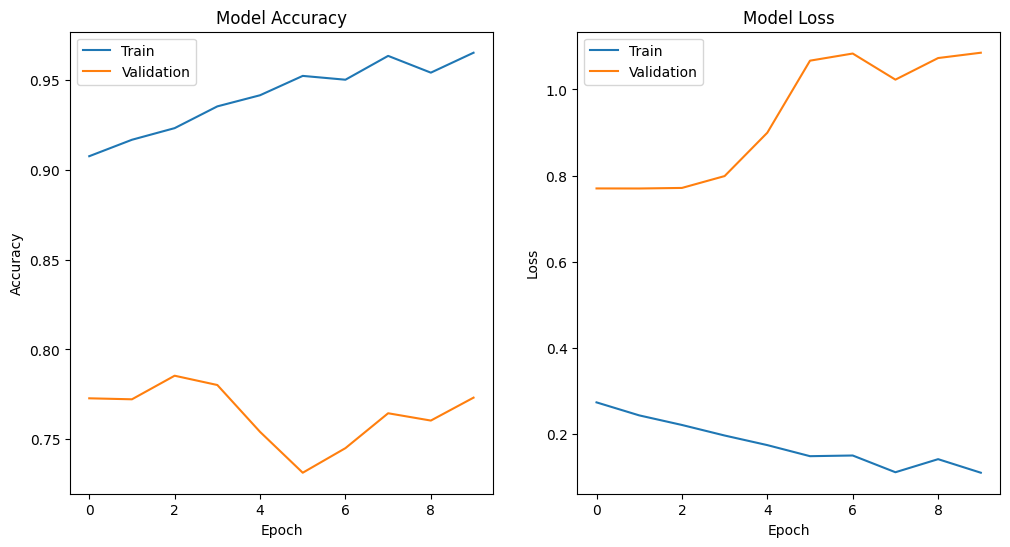

In [37]:
# Train the CNN model
history = cnn_model.fit_generator(
    cnn_train_generator,
    steps_per_epoch=len(cnn_train_generator),
    epochs=10,
    validation_data=cnn_test_generator,
    validation_steps=len(cnn_test_generator)
)

# Evaluate the CNN model
cnn_eval = cnn_model.evaluate_generator(cnn_test_generator, steps=len(cnn_test_generator))
print("CNN Model - Test Accuracy: {:.4f}".format(cnn_eval[1]))

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


<ipython-input-38-a8515dc8eb06>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_cnn = cnn_model.predict_generator(cnn_test_generator, steps=len(cnn_test_generator))



Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.80       600
           1       0.97      0.92      0.94       600
           2       0.69      0.69      0.69       600
           3       0.59      0.59      0.59       500
           4       0.83      0.87      0.85       500
           5       0.76      0.74      0.75       400
           6       0.56      0.64      0.60       500
           7       0.82      0.86      0.84       600
           8       0.67      0.61      0.64       500
           9       0.97      0.94      0.96       600

    accuracy                           0.77      5400
   macro avg       0.77      0.77      0.77      5400
weighted avg       0.78      0.77      0.77      5400



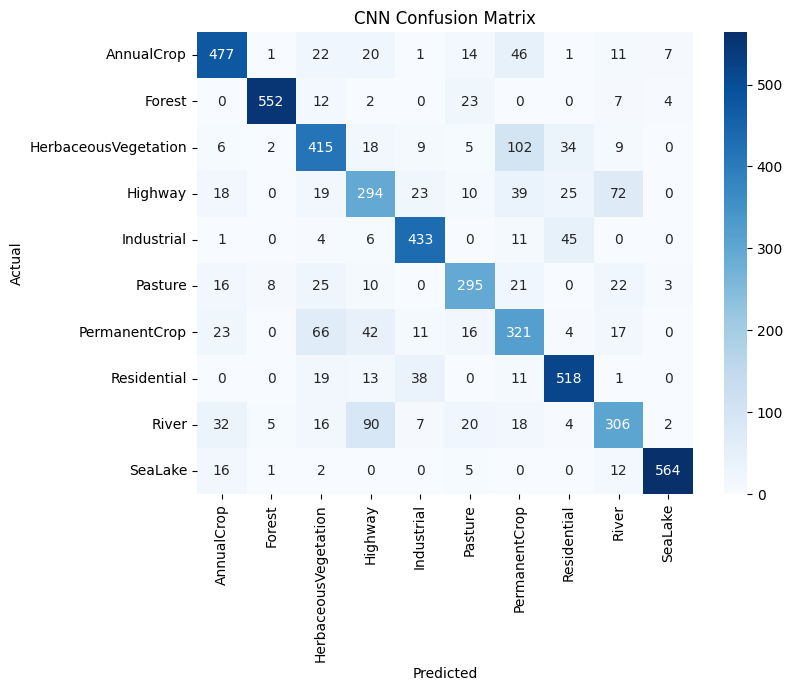

In [38]:
# Predictions on test data
y_pred_cnn = cnn_model.predict_generator(cnn_test_generator, steps=len(cnn_test_generator))
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(cnn_test_generator.classes, y_pred_classes_cnn))

# Confusion Matrix
cm_cnn = confusion_matrix(cnn_test_generator.classes, y_pred_classes_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=cnn_test_generator.class_indices.keys(), yticklabels=cnn_test_generator.class_indices.keys())
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

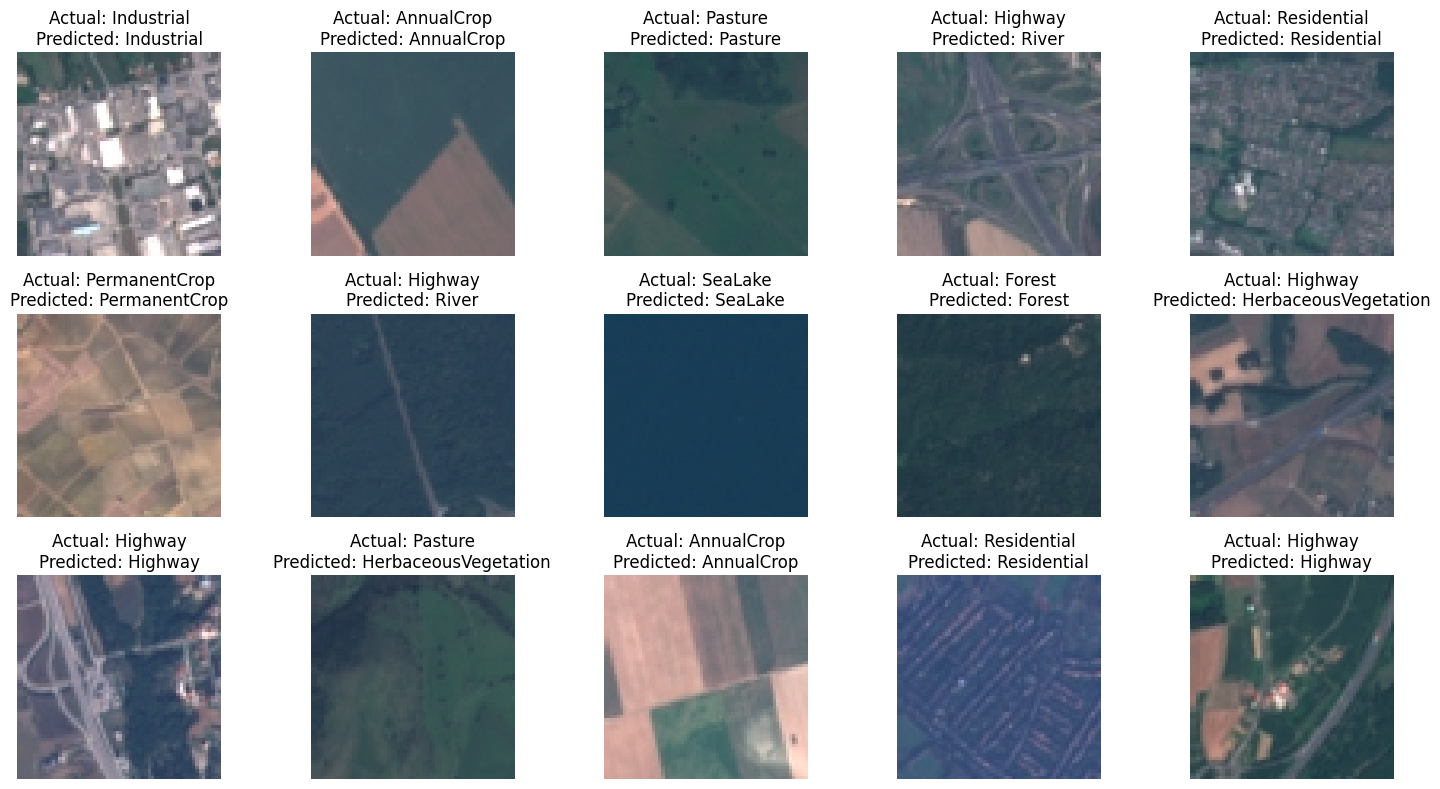

In [48]:
# Visualize some actual vs predicted samples
num_samples_to_visualize = 15
num_rows = 3
num_cols = num_samples_to_visualize // num_rows

sample_ids = np.random.choice(len(cnn_test_generator.filenames), size=num_samples_to_visualize, replace=False)

plt.figure(figsize=(15, 8))
for i, sample_id in enumerate(sample_ids):
    plt.subplot(num_rows, num_cols, i + 1)

    actual_class = cnn_test_generator.classes[sample_id]
    predicted_class = y_pred_classes_cnn[sample_id]

    plt.imshow(plt.imread(TEST_DIR + '/' + cnn_test_generator.filenames[sample_id]))

    # Convert class_indices.keys() to a list before indexing
    classes_list = list(cnn_test_generator.class_indices.keys())

    plt.title(f"Actual: {classes_list[actual_class]}\nPredicted: {classes_list[predicted_class]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### InceptionV3 Model (Transfer Learning)

In [18]:
# Image data generators for training and testing
cnn_gen = ImageDataGenerator(rescale=1./255)

cnn_train_generator = cnn_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(75, 75),
    batch_size=32,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    seed=7
)

cnn_test_generator = cnn_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(75, 75),
    batch_size=32,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False,
    seed=7
)


Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [21]:
# Load the InceptionV3 model pre-trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for your classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_labels, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_transfer_learning = model.fit_generator(
    cnn_train_generator,
    steps_per_epoch=len(cnn_train_generator),
    epochs=10,
    validation_data=cnn_test_generator,
    validation_steps=len(cnn_test_generator)
)

# Evaluate the transfer learning model
eval_transfer_learning = model.evaluate_generator(cnn_test_generator, steps=len(cnn_test_generator))
print("Transfer Learning Model - Test Accuracy: {:.4f}".format(eval_transfer_learning[1]))

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-21-ce63002a6616>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_transfer_learning = model.fit_generator(


Epoch 1/10
675/675 [==============================] - 345s 503ms/step - loss: 0.6575 - accuracy: 0.7806 - val_loss: 0.5251 - val_accuracy: 0.8194
Epoch 2/10
675/675 [==============================] - 319s 473ms/step - loss: 0.4373 - accuracy: 0.8493 - val_loss: 0.5281 - val_accuracy: 0.8207
Epoch 3/10
675/675 [==============================] - 286s 424ms/step - loss: 0.3535 - accuracy: 0.8773 - val_loss: 0.5561 - val_accuracy: 0.8204
Epoch 4/10
675/675 [==============================] - 313s 464ms/step - loss: 0.2903 - accuracy: 0.8987 - val_loss: 0.5303 - val_accuracy: 0.8285
Epoch 5/10
675/675 [==============================] - 313s 464ms/step - loss: 0.2309 - accuracy: 0.9207 - val_loss: 0.5622 - val_accuracy: 0.8281
Epoch 6/10
675/675 [==============================] - 280s 415ms/step - loss: 0.1861 - accuracy: 0.9377 - val_loss: 0.5708 - val_accuracy: 0.8281
Epoch 7/10
675/675 [==============================] - 310s 460ms/step - loss: 0.1431 - accuracy: 0.9522 - val_loss: 0.6223 -

<ipython-input-21-ce63002a6616>:30: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  eval_transfer_learning = model.evaluate_generator(cnn_test_generator, steps=len(cnn_test_generator))


Transfer Learning Model - Test Accuracy: 0.8183


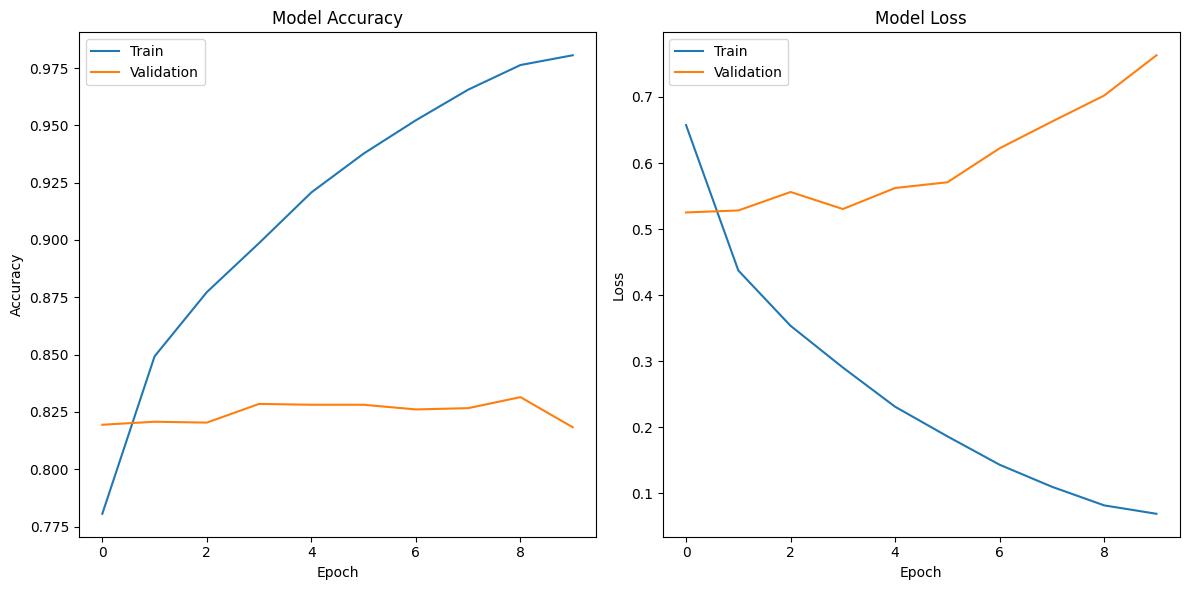

In [22]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_transfer_learning.history['accuracy'])
plt.plot(history_transfer_learning.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer_learning.history['loss'])
plt.plot(history_transfer_learning.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

<ipython-input-25-83550b708884>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_transfer_learning = model.predict_generator(cnn_test_generator, steps=len(cnn_test_generator))



Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       600
           1       0.85      0.95      0.89       600
           2       0.80      0.81      0.80       600
           3       0.63      0.78      0.69       500
           4       0.86      0.90      0.88       500
           5       0.83      0.70      0.76       400
           6       0.73      0.70      0.71       500
           7       0.90      0.81      0.86       600
           8       0.78      0.71      0.74       500
           9       0.97      0.91      0.94       600

    accuracy                           0.82      5400
   macro avg       0.82      0.81      0.81      5400
weighted avg       0.82      0.82      0.82      5400



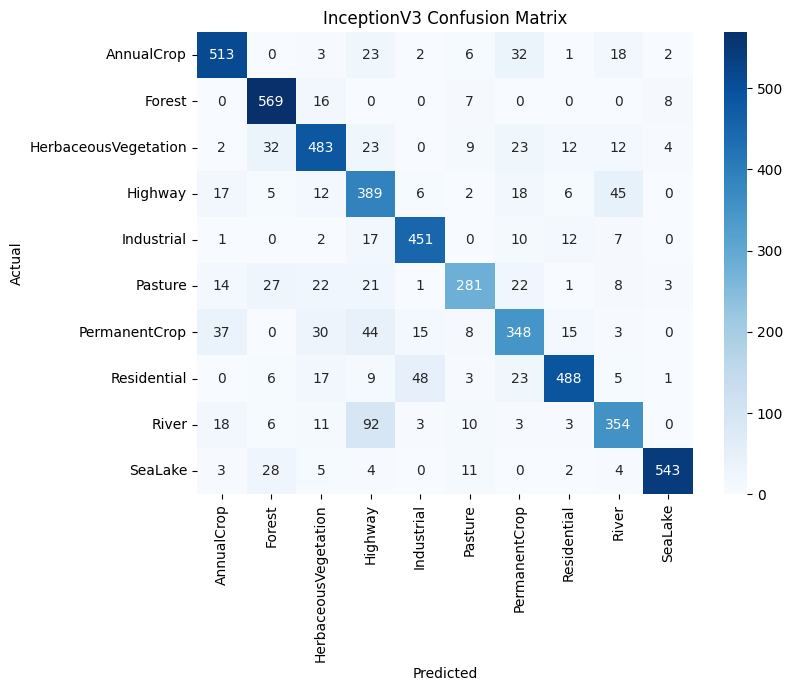

In [25]:
# Predictions on test data
y_pred_transfer_learning = model.predict_generator(cnn_test_generator, steps=len(cnn_test_generator))
y_pred_classes_transfer_learning = np.argmax(y_pred_transfer_learning, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(cnn_test_generator.classes, y_pred_classes_transfer_learning))

# Confusion Matrix
cm_transfer_learning = confusion_matrix(cnn_test_generator.classes, y_pred_classes_transfer_learning)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_transfer_learning, annot=True, fmt="d", cmap="Blues", xticklabels=cnn_test_generator.class_indices.keys(), yticklabels=cnn_test_generator.class_indices.keys())
plt.title("InceptionV3 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

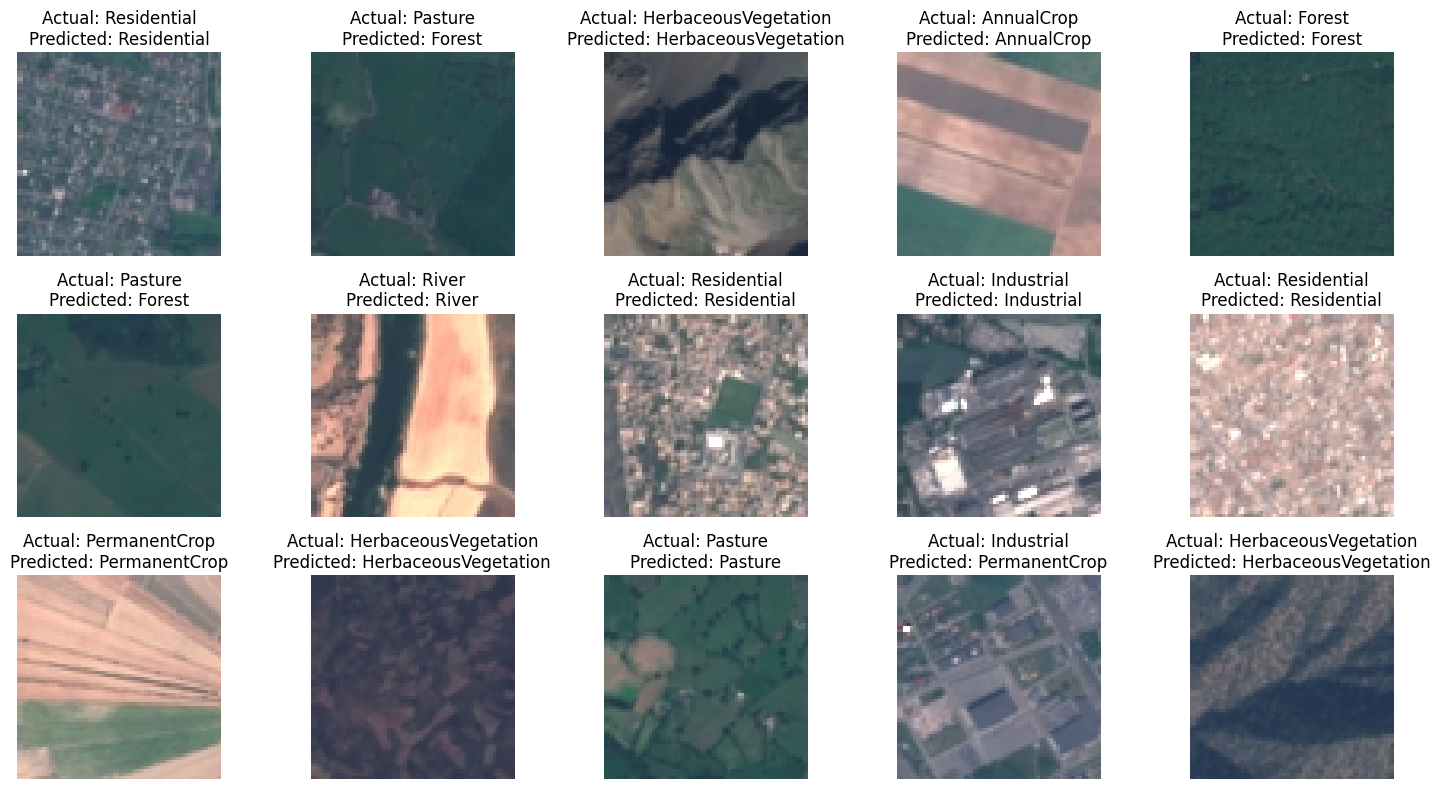

In [27]:
# Visualize some actual vs predicted samples
num_samples_to_visualize = 15
num_rows_visualize = 3
num_cols_visualize = num_samples_to_visualize // num_rows_visualize

sample_ids_transfer_learning = np.random.choice(len(cnn_test_generator.filenames), size=num_samples_to_visualize, replace=False)

plt.figure(figsize=(15, 8))
for i, sample_id in enumerate(sample_ids_transfer_learning):
    plt.subplot(num_rows_visualize, num_cols_visualize, i + 1)

    actual_class_transfer_learning = cnn_test_generator.classes[sample_id]
    predicted_class_transfer_learning = y_pred_classes_transfer_learning[sample_id]

    plt.imshow(plt.imread(TEST_DIR + '/' + cnn_test_generator.filenames[sample_id]))

    # Convert class_indices.keys() to a list before indexing
    classes_list_transfer_learning = list(cnn_test_generator.class_indices.keys())

    plt.title(f"Actual: {classes_list_transfer_learning[actual_class_transfer_learning]}\nPredicted: {classes_list_transfer_learning[predicted_class_transfer_learning]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
